<a href="https://colab.research.google.com/github/ikramnoun/self-driving-car/blob/main/trafic_signs_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs.git

Cloning into 'german-traffic-signs'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (6/6), 117.80 MiB | 5.33 MiB/s, done.
Updating files: 100% (4/4), done.


In [ ]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
import pickle
import pandas as pd
import random
import cv2

In [ ]:
with open ('/content/german-traffic-signs/test.p','rb') as f:
  test_data=pickle.load(f)
with open ('/content/german-traffic-signs/train.p','rb') as f:
  train_data=pickle.load(f)
with open ('/content/german-traffic-signs/valid.p','rb') as f:
  valid_data=pickle.load(f)

x_train,y_train= train_data['features'], train_data['labels']
x_valid,y_valid= valid_data['features'], valid_data['labels']
x_test,y_test= test_data['features'], test_data['labels']

In [ ]:
print(x_train.shape)
print(x_valid.shape)
print(x_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [ ]:
data= pd.read_csv("/content/german-traffic-signs/signnames.csv")
data.head()

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


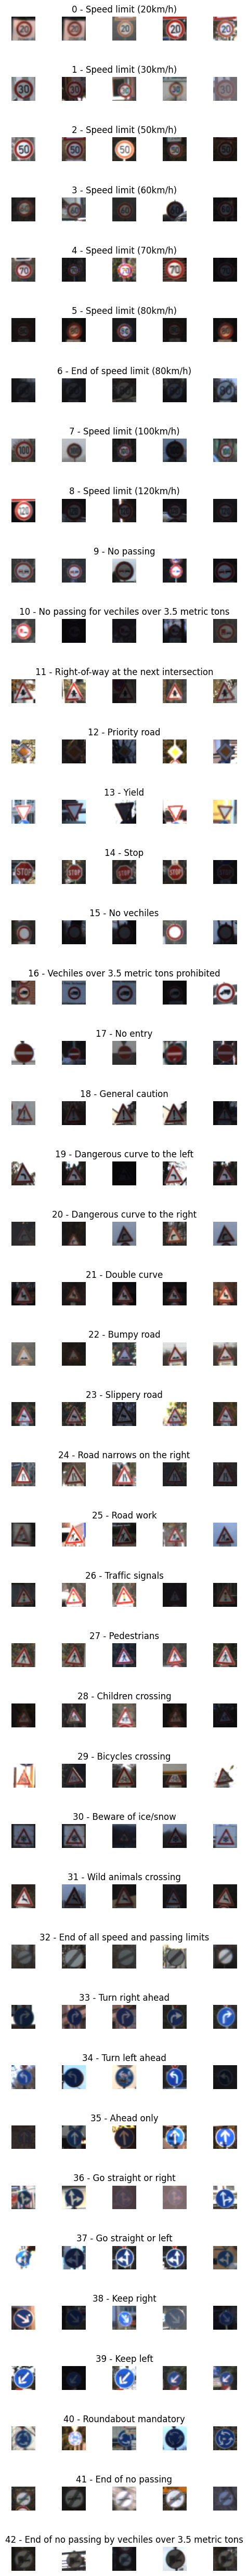

In [ ]:
num_of_samples=[]
cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()

for i in range(cols):
    for j, row in data.iterrows():
        x_selected = x_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
        axs[j][i].axis("off")
        if i == 2:
          axs[j][i].set_title(str(j) + " - " + row["SignName"])
          num_of_samples.append(len(x_selected))

Text(0.5, 0, 'num_of_classes')

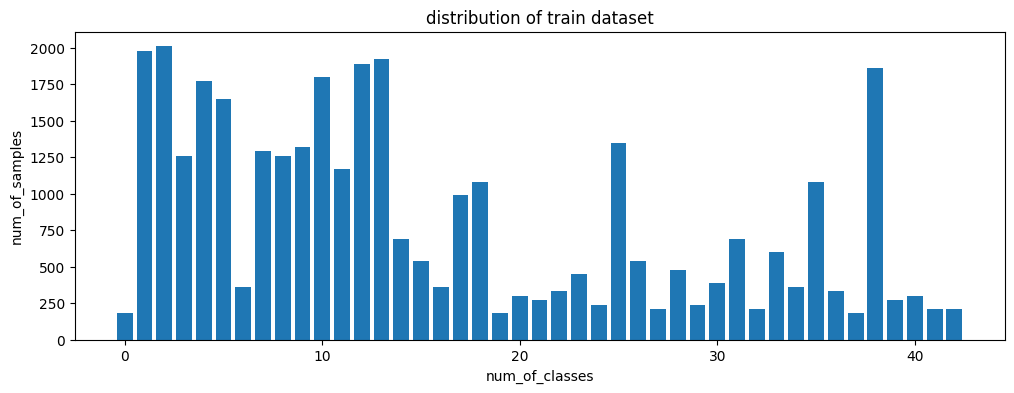

In [ ]:
plt.figure(figsize=(12,4))
plt.bar(range(0,num_classes),num_of_samples)
plt.title("distribution of train dataset")
plt.ylabel("num_of_samples")
plt.xlabel("num_of_classes")

(32, 32, 3)
1


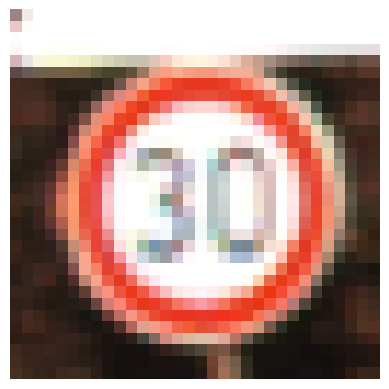

In [ ]:
plt.imshow(x_train[3000])
plt.axis("off")
print(x_train[3000].shape)
print(y_train[3000])

(32, 32)


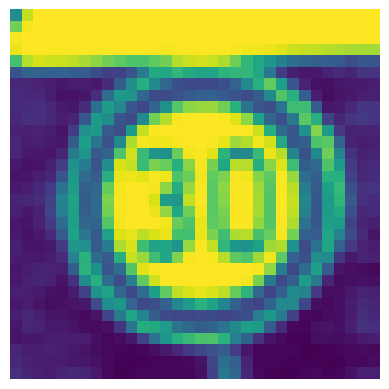

In [ ]:
def grayscale(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img

img = grayscale(x_train[3000])
plt.imshow(img)
plt.axis("off")
print(img.shape)

(32, 32)


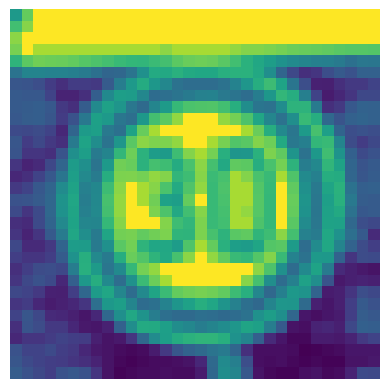

In [ ]:
def equalize(img):
  img = cv2.equalizeHist(img)
  return img


img = equalize(img)
plt.imshow(img)
plt.axis('off')
print(img.shape)

(32, 32)


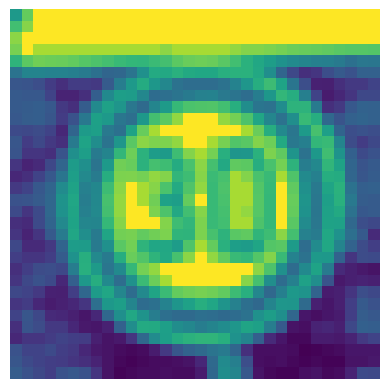

In [ ]:
def preprocessing(img):
  img = grayscale(img)
  img = equalize(img)
  img = img/255
  return img

img=x_train[3000]
img = preprocessing(img)
plt.imshow(img)
plt.axis('off')
print(img.shape)

In [ ]:
x_train=np.array(list(map(preprocessing,x_train)))
x_test=np.array(list(map(preprocessing,x_test)))
x_valid=np.array(list(map(preprocessing,x_valid)))

In [ ]:
x_train = x_train.reshape(34799, 32, 32, 1)
x_val = x_valid.reshape(4410, 32, 32, 1)
x_test = x_test.reshape(12630, 32, 32, 1)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_image_generator = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10.)

train_image_generator.fit(x_train)

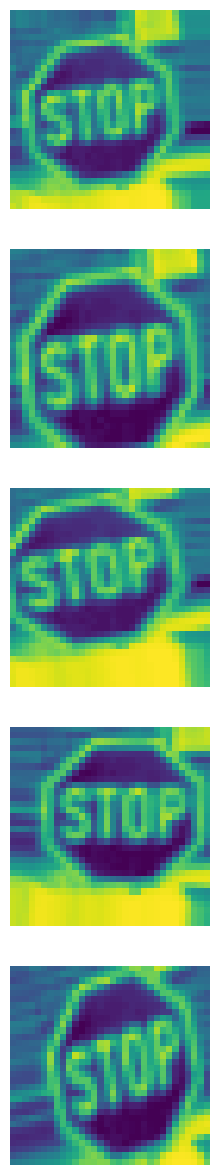

In [ ]:
train_data_gen=train_image_generator.flow(x_train,y_train,batch_size=15)
augmented_images = [train_data_gen[0][0][0] for i in range(5)]

fig,axes=plt.subplots(len(augmented_images),1,figsize=(5,15))
for img,ax in zip(augmented_images,axes):
  ax.imshow(img)
  ax.axis("off")
plt.show()

In [ ]:
y_train= to_categorical(y_train,43)
y_test= to_categorical(y_test,43)
y_valid= to_categorical(y_valid,43)

In [ ]:
model = Sequential()
model.add(Conv2D(32,(3,3), input_shape= (32,32,1), activation = 'relu'))
model.add(Conv2D(32,(3,3), input_shape= (32,32,1), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(64, (3, 3) , activation = 'relu'))
model.add(Conv2D(64, (3, 3) , activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation = 'softmax'))
model.compile(Adam(lr = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 30, 30, 32)        320       
                                                                 
 conv2d_31 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 14, 14, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_32 (Conv2D)          (None, 12, 12, 64)        18496     
                                                                 
 conv2d_33 (Conv2D)          (None, 10, 10, 64)        36928     
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 5, 5, 64)          0         
 ng2D)                                                

In [ ]:
history = model.fit_generator(train_image_generator.flow(x_train, y_train, batch_size=50),
                            steps_per_epoch=200,
                            epochs=15,
                            validation_data=(x_valid, y_valid), shuffle = 1)

Epoch 1/15


<ipython-input-52-cd4aec1fb9b9>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_image_generator.flow(x_train, y_train, batch_size=50),


200/200 [==============================] - 9s 28ms/step - loss: 2.9007 - accuracy: 0.2206 - val_loss: 1.4823 - val_accuracy: 0.5594
Epoch 2/15
200/200 [==============================] - 6s 28ms/step - loss: 1.5243 - accuracy: 0.5349 - val_loss: 0.6247 - val_accuracy: 0.8132
Epoch 3/15
200/200 [==============================] - 5s 24ms/step - loss: 0.9425 - accuracy: 0.7051 - val_loss: 0.3189 - val_accuracy: 0.9002
Epoch 4/15
200/200 [==============================] - 5s 23ms/step - loss: 0.6655 - accuracy: 0.7899 - val_loss: 0.1791 - val_accuracy: 0.9492
Epoch 5/15
200/200 [==============================] - 5s 26ms/step - loss: 0.4822 - accuracy: 0.8524 - val_loss: 0.1711 - val_accuracy: 0.9444
Epoch 6/15
200/200 [==============================] - 5s 23ms/step - loss: 0.4023 - accuracy: 0.8778 - val_loss: 0.1625 - val_accuracy: 0.9454
Epoch 7/15
200/200 [==============================] - 5s 27ms/step - loss: 0.3424 - accuracy: 0.8959 - val_loss: 0.0980 - val_accuracy: 0.9730
Epoch 8/15

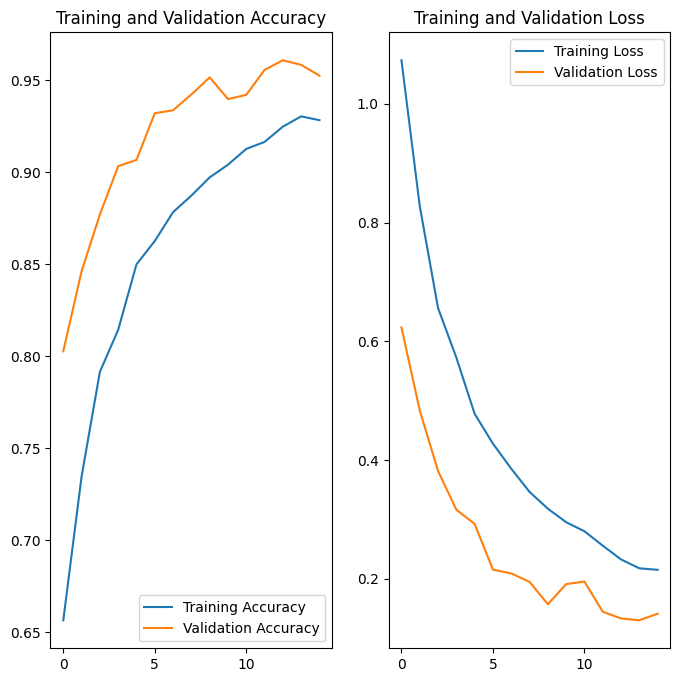

In [ ]:
epochs=15
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
score = model.evaluate(x_test, y_test , verbose = 0)
print("The test score is: ",score[0])
print("The Accuracy score is: ",score[1])

The test score is:  0.13989780843257904
The Accuracy score is:  0.9623911380767822


In [ ]:
model.save('my_model.h5')